# Modélisation

Importation des modules

In [ ]:
 !pip install mord

In [3]:
import pandas as pd  
import numpy as np, pandas as pd, matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import mannwhitneyu, norm
import chardet
import unicodedata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mord as m
from patsy import dmatrices


## Importation des bases de données

In [4]:
base_finale= pd.read_csv("base_finale.csv", delimiter=",", low_memory=False)
base_f= pd.read_csv("base_f.csv", delimiter=",", low_memory=False)

In [5]:
base_finale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126080 entries, 0 to 126079
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     126080 non-null  int64  
 1   Num_Acc        126080 non-null  int64  
 2   id_vehicule    126080 non-null  object 
 3   num_veh        126080 non-null  object 
 4   place          126080 non-null  int64  
 5   catu           126080 non-null  int64  
 6   grav           126080 non-null  int64  
 7   sexe           126080 non-null  int64  
 8   an_nais        126080 non-null  float64
 9   trajet         126080 non-null  object 
 10  secu1          126080 non-null  object 
 11  secu2          126080 non-null  object 
 12  actp           126080 non-null  object 
 13  senc           126080 non-null  object 
 14  catv           126080 non-null  object 
 15  obs            126080 non-null  object 
 16  obsm           126080 non-null  object 
 17  choc           126080 non-nul

In [6]:
base_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126080 entries, 0 to 126079
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     126080 non-null  int64  
 1   Num_Acc        126080 non-null  int64  
 2   id_vehicule    126080 non-null  object 
 3   num_veh        126080 non-null  object 
 4   place          126080 non-null  int64  
 5   catu           126080 non-null  object 
 6   grav           126080 non-null  int64  
 7   sexe           126080 non-null  object 
 8   an_nais        126080 non-null  float64
 9   trajet         126080 non-null  object 
 10  secu1          126080 non-null  object 
 11  secu2          126080 non-null  object 
 12  actp           126080 non-null  object 
 13  senc           126080 non-null  object 
 14  catv           126080 non-null  object 
 15  obs            126080 non-null  object 
 16  obsm           126080 non-null  object 
 17  choc           126080 non-nul

## Analyse sur la base base_f

Régression logistique : prédire la gravité
* Objectif : prédire si un usager est blessé (grav > 1) ou indemne.
* Quels facteurs (âge, sexe, type de véhicule, conditions météo, etc.) augmentent la probabilité d’être blessé ?

In [ ]:
# 1. Création de la variable cible binaire : 0 = indemne, 1 = blessé/tué
base_f['cible_blesse'] = base_f['grav'].apply(lambda x: 0 if x == 1 else 1)

# 2. Liste des variables explicatives
variables = ['sexe', 'age', 'catv', 'catu', 'atm', 'lum', 'trajet', 'secu1', 'choc', 'manv', 'agg']

# 3. Sélection et suppression des lignes incomplètes
df_model = base_f[variables + ['cible_blesse']].dropna()

# 4. Encodage des variables catégorielles en variables binaires
X = pd.get_dummies(df_model.drop('cible_blesse', axis=1), drop_first=True)
X = X.astype(float)  #  Conversion explicite

y = df_model['cible_blesse'].astype(int)  #  Conversion explicite

# 5. Séparation en train et test (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 6. Ajout de constante (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# 7. Ajustement du modèle sur le jeu d'entraînement
model = sm.GLM(y_train, X_train_const, family=sm.families.Binomial())
result = model.fit()

# 8. Résultats sur le modèle entraîné
print("=== Résultats du GLM logistique (entraînement) ===")
print(result.summary())

# 9. Prédictions sur les données test
y_pred_proba = result.predict(X_test_const)
y_pred = (y_pred_proba >= 0.5).astype(int)

# 10. Évaluation du modèle
print("\n=== Évaluation sur le jeu de test ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred):.3f}")


=== Résultats du GLM logistique (entraînement) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           cible_blesse   No. Observations:                88256
Model:                            GLM   Df Residuals:                    88200
Model Family:                Binomial   Df Model:                           55
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44462.
Date:                Sat, 17 May 2025   Deviance:                       88924.
Time:                        22:50:01   Pearson chi2:                 1.11e+05
No. Iterations:                    19   Pseudo R-squ. (CS):             0.2936
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

Tableau d’odds ratios lisible

In [15]:
# Extraction des résultats
params = result.params
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']

# Calcul des odds ratios
odds_ratios = np.exp(params)
conf['OR'] = odds_ratios
conf['p-value'] = result.pvalues
conf = conf[['OR', '2.5%', '97.5%', 'p-value']]

# Affichage
print("=== Odds Ratios avec intervalles de confiance et p-values ===")
print(conf.sort_values(by='OR', ascending=False).round(3))


=== Odds Ratios avec intervalles de confiance et p-values ===
                                                     OR       2.5%      97.5%  \
secu1_Gants + Airbag                       3.789715e+07 -34733.436  34768.337   
catu_Piéton                                2.771000e+01      3.138      3.506   
const                                      7.631000e+00      0.557      3.508   
catv_Deux-roues non motorisés              4.852000e+00      0.878      2.281   
choc_Multichoc_(tonneaux)                  4.706000e+00      1.389      1.709   
catv_Deux-roues motorisés                  2.555000e+00      0.238      1.638   
agg_Hors agglomeration                     2.246000e+00      0.772      0.846   
catu_Passager                              1.829000e+00      0.560      0.647   
catv_Véhicules professionnels spécialisés  1.721000e+00     -0.166      1.252   
catv_Véhicules agricoles / spéciaux        1.689000e+00     -0.180      1.229   
lum_Nuit sans éclairage public             1.30

In [17]:
print("\n=== Interprétation automatisée des facteurs significatifs ===")

for var, row in conf.iterrows():
    if row['p-value'] < 0.05:
        if row['OR'] > 1:
            print(f"✅ La variable '{var}' augmente la probabilité d'être blessé (OR = {row['OR']:.2f}).")
        else:
            print(f"🔻 La variable '{var}' diminue la probabilité d'être blessé (OR = {row['OR']:.2f}).")
    else:
        print(f"⏸️ La variable '{var}' n’est pas significative (p = {row['p-value']:.3f}).")



=== Interprétation automatisée des facteurs significatifs ===
✅ La variable 'const' augmente la probabilité d'être blessé (OR = 7.63).
⏸️ La variable 'age' n’est pas significative (p = 0.782).
🔻 La variable 'sexe_Homme' diminue la probabilité d'être blessé (OR = 0.61).
⏸️ La variable 'catv_Autre' n’est pas significative (p = 0.453).
✅ La variable 'catv_Deux-roues motorisés' augmente la probabilité d'être blessé (OR = 2.55).
✅ La variable 'catv_Deux-roues non motorisés' augmente la probabilité d'être blessé (OR = 4.85).
🔻 La variable 'catv_Poids lourds' diminue la probabilité d'être blessé (OR = 0.17).
🔻 La variable 'catv_Transport en commun' diminue la probabilité d'être blessé (OR = 0.32).
⏸️ La variable 'catv_Véhicules agricoles / spéciaux' n’est pas significative (p = 0.145).
⏸️ La variable 'catv_Véhicules légers' n’est pas significative (p = 0.056).
🔻 La variable 'catv_Véhicules légers pro' diminue la probabilité d'être blessé (OR = 0.33).
⏸️ La variable 'catv_Véhicules profession

sans entrainement

In [19]:
# 1. Création de la variable cible binaire (0 = indemne, 1 = blessé ou tué)
base_f['cible_blesse'] = base_f['grav'].apply(lambda x: 0 if x == 1 else 1)

# 2. Définition des variables explicatives
variables = ['sexe', 'age', 'catv', 'catu', 'atm', 'lum', 'trajet', 'secu1', 'choc', 'manv', 'agg']

# 3. Sélection des colonnes utiles et suppression des valeurs manquantes
df_model = base_f[variables + ['cible_blesse']].dropna()

# 4. Encodage des variables catégorielles (get_dummies)
X = pd.get_dummies(df_model.drop('cible_blesse', axis=1), drop_first=True)
X = X.astype(float)  # ✅ Conversion explicite pour éviter l'erreur

# 5. Ajout de constante pour l'interception
X = sm.add_constant(X)

# 6. Variable cible
y = df_model['cible_blesse'].astype(int)  # ✅ Conversion explicite

# 7. Ajustement du modèle GLM logistique
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()

# 8. Affichage du résumé du modèle
print("=== Résultats du GLM logistique : probabilité d’être blessé ou tué ===")
print(result.summary())


=== Résultats du GLM logistique : probabilité d’être blessé ou tué ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           cible_blesse   No. Observations:               126080
Model:                            GLM   Df Residuals:                   126024
Model Family:                Binomial   Df Model:                           55
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63669.
Date:                Sat, 17 May 2025   Deviance:                   1.2734e+05
Time:                        22:55:35   Pearson chi2:                 1.59e+05
No. Iterations:                    20   Pseudo R-squ. (CS):             0.2925
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### Modèle multinomial

* Comment les variables influencent la probabilité d’appartenir à chaque niveau de gravité ?
* Par exemple, les deux-roues augmentent-ils spécifiquement le risque d’hospitalisation (et pas juste d’être blessé) ?

In [ ]:
# 1. Variables explicatives et variable cible (gravité exacte)
variables = ['sexe', 'age', 'catv', 'catu', 'atm', 'lum', 'trajet', 'secu1', 'choc', 'manv','choc']
df_model = base_f[variables + ['grav']].dropna()

# 2. Encodage des variables catégorielles
X = pd.get_dummies(df_model.drop('grav', axis=1), drop_first=True)
X = X.astype(float)  # ✅ Conversion explicite pour éviter l'erreur
y = df_model['grav']  # Valeurs : 1 = Indemne, 2 = Tué, 3 = Blessé hospitalisé, 4 = Blessé léger
y = df_model['grav'].astype(int)  # ✅ Conversion explicite
# 3. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 4. Standardisation 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Modèle de régression logistique multinomiale
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
model.fit(X_train_scaled, y_train)

# 6. Prédictions et évaluation
y_pred = model.predict(X_test_scaled)

print("=== Évaluation du modèle multinomial : prédiction de la gravité exacte ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print(f"Précision (accuracy) globale : {accuracy_score(y_test, y_pred):.3f}")


c:\Users\SCD UM\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Évaluation du modèle multinomial : prédiction de la gravité exacte ===
[[13083     3   133  2521]
 [  355     9   218   434]
 [ 1644     8   764  3279]
 [ 5906     5   526  8936]]
              precision    recall  f1-score   support

           1      0.623     0.831     0.712     15740
           2      0.360     0.009     0.017      1016
           3      0.466     0.134     0.208      5695
           4      0.589     0.581     0.585     15373

    accuracy                          0.603     37824
   macro avg      0.509     0.389     0.381     37824
weighted avg      0.579     0.603     0.566     37824

Précision (accuracy) globale : 0.603


In [37]:
# On utilise gravité dans sa version d'origine (1 à 4)
#df_model_multi = base_f[variables + ['grav']].dropna()

# Encodage des variables catégorielles sous forme de formules
#formula = 'grav ~ ' + ' + '.join(variables)

# Modèle multinomial avec gravité comme variable nominale
#model_mn = smf.mnlogit(formula, data=df_model_multi).fit(method='newton', maxiter=100, full_output=True, disp=False)

#print(model_mn.summary())


Graphique de la matrice de confusion

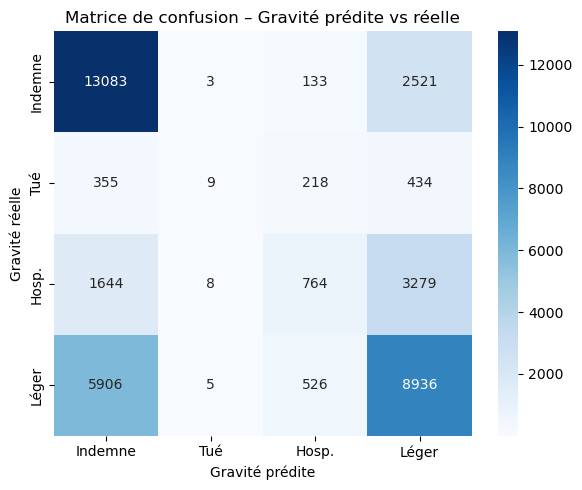

In [21]:
# Générer et afficher la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Indemne", "Tué", "Hosp.", "Léger"],
            yticklabels=["Indemne", "Tué", "Hosp.", "Léger"])
plt.title("Matrice de confusion – Gravité prédite vs réelle")
plt.xlabel("Gravité prédite")
plt.ylabel("Gravité réelle")
plt.tight_layout()
plt.show()


Analyse automatique des facteurs influents (par classe)

In [23]:
print("=== Analyse automatique des coefficients par classe ===")
classes = model.classes_
coefs = model.coef_

for i, classe in enumerate(classes):
    print(f"\n➡ Gravité prédite : {classe}")
    top_vars = pd.Series(coefs[i], index=X.columns).sort_values(ascending=False)
    
    print("✅ Facteurs qui augmentent la probabilité :")
    print(top_vars.head(5).round(3))
    
    print("🔻 Facteurs qui la diminuent :")
    print(top_vars.tail(5).round(3))


=== Analyse automatique des coefficients par classe ===

➡ Gravité prédite : 1
✅ Facteurs qui augmentent la probabilité :
secu1_Ceinture               0.351
manv_Ouverture de porte      0.170
catv_Véhicules légers        0.160
manv_Changement de voie      0.153
catv_Véhicules légers pro    0.153
dtype: float64
🔻 Facteurs qui la diminuent :
secu1_Aucun                     -0.195
catv_Deux-roues non motorisés   -0.200
catv_Deux-roues motorisés       -0.246
secu1_Casque                    -0.263
catu_Piéton                     -0.505
dtype: float64

➡ Gravité prédite : 2
✅ Facteurs qui augmentent la probabilité :
age                               0.366
secu1_Aucun                       0.286
trajet_Promenade-loisirs          0.176
lum_Nuit sans éclairage public    0.172
choc_Avant                        0.157
dtype: float64
🔻 Facteurs qui la diminuent :
manv_Stationnement/Arrêt                    -0.091
catv_Véhicules professionnels spécialisés   -0.094
lum_Nuit éclairage allumé          

comparer au logit ordinal

In [35]:
# Régression logistique ordinale
ord_model = m.LogisticAT(alpha=1.0)
ord_model.fit(X_train_scaled, y_train)
y_pred_ord = ord_model.predict(X_test_scaled)

# Évaluation
print("=== Évaluation du modèle ordinal (LogisticAT) ===")
print(confusion_matrix(y_test, y_pred_ord))
print(classification_report(y_test, y_pred_ord, digits=3))
print(f"Précision (accuracy) : {accuracy_score(y_test, y_pred_ord):.3f}")

# ---  Conclusion automatique ---
print("\n=== Conclusion sur le choix du modèle ===")
if accuracy_multi > accuracy_ord:
    print(f"Le modèle **multinomial** présente de meilleures performances (accuracy = {accuracy_multi:.3f}) "
          f"que le modèle ordinal (accuracy = {accuracy_ord:.3f}). Le modèle **multinomial** est donc retenu.")
elif accuracy_ord > accuracy_multi:
    print(f"Le modèle **ordinal** présente de meilleures performances (accuracy = {accuracy_ord:.3f}) "
          f"que le modèle multinomial (accuracy = {accuracy_multi:.3f}). Le modèle **ordinal** est donc retenu.")
else:
    print(f"Les deux modèles présentent une performance équivalente (accuracy = {accuracy_ord:.3f}). "
          "Le choix dépendra alors d'autres critères comme l'interprétabilité.")


=== Évaluation du modèle ordinal (LogisticAT) ===
[[10306  5283   151     0]
 [ 3961 10401  1011     0]
 [  527  4024  1143     1]
 [   80   647   289     0]]
              precision    recall  f1-score   support

           0      0.693     0.655     0.673     15740
           1      0.511     0.677     0.582     15373
           2      0.441     0.201     0.276      5695
           3      0.000     0.000     0.000      1016

    accuracy                          0.578     37824
   macro avg      0.411     0.383     0.383     37824
weighted avg      0.562     0.578     0.558     37824

Précision (accuracy) : 0.578

=== Conclusion sur le choix du modèle ===
Le modèle **multinomial** présente de meilleures performances (accuracy = 0.611) que le modèle ordinal (accuracy = 0.578). Le modèle **multinomial** est donc retenu.


## logit ordinal

In [ ]:
# 1. Sélection des variables explicatives ( suppression du doublon 'choc')
variables = ['sexe', 'age', 'catv', 'catu', 'atm', 'lum', 'trajet', 'secu1', 'choc', 'manv', 'agg']

# 2. Création du DataFrame propre pour la modélisation
df_model = base_f[variables + ['ordre_gravite']].dropna()

# 3. Encodage des variables catégorielles
X = pd.get_dummies(df_model.drop('ordre_gravite', axis=1), drop_first=True).astype(float)

# 4. Définition de la variable cible (ordre_gravite)
y = df_model['ordre_gravite'].astype(int)

# 5. Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 6. Standardisation des variables explicatives
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Modèle de logit ordinal (Adjacent Threshold)
model = mord.LogisticAT(alpha=1.0)
model.fit(X_train_scaled, y_train)

# 8. Prédictions sur les données test
y_pred = model.predict(X_test_scaled)

# 9. Évaluation du modèle
print("=== Évaluation du modèle de logit ordinal : prédiction de la gravité ordinale ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print(f"Précision (accuracy) globale : {accuracy_score(y_test, y_pred):.3f}")

# 10. Affichage des coefficients et des seuils
print("\n=== Résumé du modèle de logit ordinal (coefficients et seuils) ===")
coefficients = pd.Series(model.coef_, index=X.columns)
print("\n--- Coefficients des variables explicatives ---")
print(coefficients.sort_values(ascending=False))

print("\n--- Seuils de coupure (intercepts entre les catégories) ---")
print(model.theta_)



=== Évaluation du modèle de logit ordinal : prédiction de la gravité ordinale ===
[[10306  5283   151     0]
 [ 3961 10401  1011     0]
 [  527  4024  1143     1]
 [   80   647   289     0]]
              precision    recall  f1-score   support

           0      0.693     0.655     0.673     15740
           1      0.511     0.677     0.582     15373
           2      0.441     0.201     0.276      5695
           3      0.000     0.000     0.000      1016

    accuracy                          0.578     37824
   macro avg      0.411     0.383     0.383     37824
weighted avg      0.562     0.578     0.558     37824

Précision (accuracy) globale : 0.578

=== Résumé du modèle de logit ordinal (coefficients et seuils) ===

--- Coefficients des variables explicatives ---
agg_Hors agglomeration                       0.490824
choc_Avant                                   0.223823
catu_Piéton                                  0.215271
choc_Multichoc_(tonneaux)                    0.172158
catu

matrice de confusion

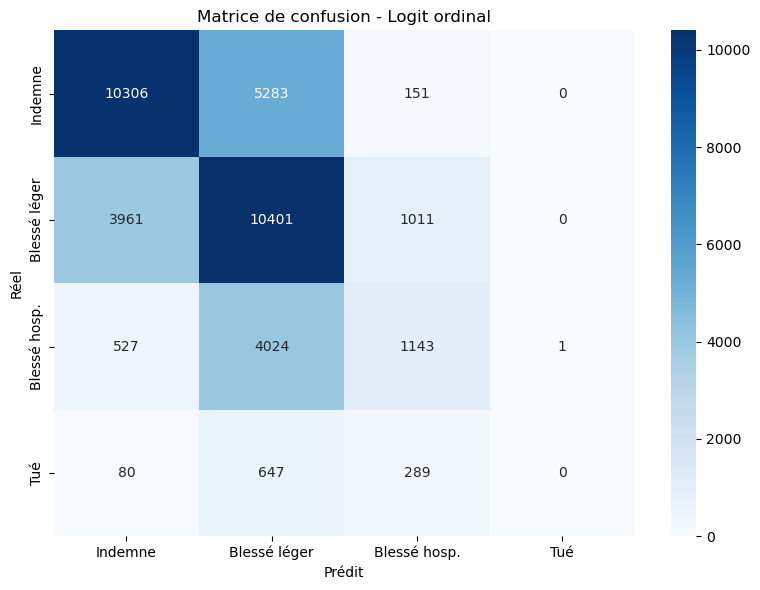

In [29]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Indemne", "Blessé léger", "Blessé hosp.", "Tué"],
            yticklabels=["Indemne", "Blessé léger", "Blessé hosp.", "Tué"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Logit ordinal")
plt.tight_layout()
plt.show()


Analyse automatique des facteurs influents pour chaque classe

In [31]:
top_n = 5

# Création du DataFrame des coefficients
summary_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': model.coef_
})

# Trier pour extraire les plus influents
print("\n=== Principaux facteurs associés à une gravité PLUS élevée ===")
print(summary_df[summary_df['Coefficient'] > 0]
      .sort_values(by='Coefficient', ascending=False)
      .head(top_n)
      .to_string(index=False))

print("\n=== Principaux facteurs associés à une gravité MOINS élevée ===")
print(summary_df[summary_df['Coefficient'] < 0]
      .sort_values(by='Coefficient', ascending=True)
      .head(top_n)
      .to_string(index=False))



=== Principaux facteurs associés à une gravité PLUS élevée ===
                 Variable  Coefficient
   agg_Hors agglomeration     0.490824
               choc_Avant     0.223823
              catu_Piéton     0.215271
choc_Multichoc_(tonneaux)     0.172158
            catu_Passager     0.161869

=== Principaux facteurs associés à une gravité MOINS élevée ===
                 Variable  Coefficient
           secu1_Ceinture    -0.802470
      secu1_Non renseigné    -0.231639
catv_Véhicules légers pro    -0.176231
        catv_Poids lourds    -0.175403
  manv_Ouverture de porte    -0.160098


Comparaison avec une régression logistique multinomiale

In [33]:
# Comparaison des performances globales
accuracy_ord = accuracy_score(y_test, y_pred)  # pour le modèle ordinal
accuracy_multi = accuracy_score(y_test, y_pred_multi)  # pour le modèle multinomial

# Choix du modèle le plus performant
if accuracy_multi > accuracy_ord:
    conclusion = ("Le modèle de régression logistique **multinomiale** présente de meilleures performances "
                  f"(accuracy = {accuracy_multi:.3f}) que le modèle ordinal (accuracy = {accuracy_ord:.3f}).\n"
                  "✅ Le modèle **multinomial** est donc retenu.")
else:
    conclusion = ("Le modèle de régression logistique **ordinale** présente de meilleures performances "
                  f"(accuracy = {accuracy_ord:.3f}) que le modèle multinomial (accuracy = {accuracy_multi:.3f}).\n"
                  "✅ Le modèle **ordinal** est donc retenu.")

print("\n=== Conclusion sur le choix du modèle ===")
print(conclusion)



=== Conclusion sur le choix du modèle ===
Le modèle de régression logistique **multinomiale** présente de meilleures performances (accuracy = 0.611) que le modèle ordinal (accuracy = 0.578).
✅ Le modèle **multinomial** est donc retenu.


In [ ]:
# On utilise gravité dans sa version d'origine (1 à 4)
df_model_multi = base_f[variables + ['grav']].dropna()

# Encodage des variables catégorielles sous forme de formules
formula = 'grav ~ ' + ' + '.join(variables)

# Modèle multinomial avec gravité comme variable nominale
model_mn = smf.mnlogit(formula, data=df_model_multi).fit(method='newton', maxiter=100, full_output=True, disp=False)

print(model_mn.summary())


c:\Users\SCD UM\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:                   grav   No. Observations:               126080
Model:                        MNLogit   Df Residuals:                   125912
Method:                           MLE   Df Model:                          165
Date:                Sat, 17 May 2025   Pseudo R-squ.:                  0.2020
Time:                        23:18:06   Log-Likelihood:            -1.1169e+05
converged:                      False   LL-Null:                   -1.3997e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      grav=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -3.4844      0.985     -3.539      0.000      -5.414      -1.555
sexe[T.Homme]                

c:\Users\SCD UM\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:5475: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


### Régression de Poisson
Modélise le nombre de victimes par accident (nb_victimes) en fonction de facteurs comme :
* type de lieu, conditions météo, nombre d’usagers, etc.
* Pour voir quels facteurs influencent le nombre de victimes dans un accident ?

In [38]:
# 1. Regrouper par accident pour obtenir le nombre de victimes par accident
df_poisson = base_f.groupby('Num_Acc').agg({
    'grav': lambda x: sum(x > 1),  # nombre de blessés (blessé léger, hospitalisé, tué)
    'lum': 'first',
    'atm': 'first',
    'nb_usagers': 'first',  # total des usagers dans l'accident
    'col': 'first',         # type de collision
    'agg': 'first',          # type de zone
    'choc':'first'
}).rename(columns={'grav': 'nb_victimes'}).dropna()

# 2. Modèle de Poisson (avec formules de patsy)
# 'C(...)' transforme les variables catégorielles en indicateurs
formula = "nb_victimes ~ C(lum) + C(atm) + nb_usagers + C(col) + C(agg)"
y, X = dmatrices(formula, data=df_poisson, return_type='dataframe')

# 3. Modèle de Poisson
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print("=== Régression de Poisson – Nombre de victimes par accident ===")
print(poisson_results.summary())


=== Régression de Poisson – Nombre de victimes par accident ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:            nb_victimes   No. Observations:                56519
Model:                            GLM   Df Residuals:                    56498
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65846.
Date:                Sat, 17 May 2025   Deviance:                       9632.7
Time:                        23:25:41   Pearson chi2:                 1.06e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1222
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Coefficients et intervalles de confiance

In [40]:
# Coefficients et intervalles de confiance
params = poisson_results.params
conf_int = poisson_results.conf_int()
conf_int.columns = ['2.5%', '97.5%']

# Calcul des Odds Ratios (exp(coef))
or_poisson = np.exp(params)
conf_int['OR'] = or_poisson
conf_int['p-value'] = poisson_results.pvalues
conf_int = conf_int[['OR', '2.5%', '97.5%', 'p-value']]

# Affichage
print("=== Effet multiplicatif (exp(coef)) sur le nombre de victimes ===")
print(conf_int.sort_values(by='OR', ascending=False).round(3))


=== Effet multiplicatif (exp(coef)) sur le nombre de victimes ===
                                         OR   2.5%  97.5%  p-value
nb_usagers                            1.213  0.189  0.198    0.000
C(col)[T.Fontale]                     1.208  0.161  0.218    0.000
C(agg)[T.Hors agglomeration]          1.129  0.105  0.138    0.000
C(col)[T.sans collision]              1.104  0.068  0.131    0.000
C(col)[T.Autre collision]             1.060  0.034  0.083    0.000
C(lum)[T.Nuit sans éclairage public]  1.059  0.020  0.094    0.002
C(lum)[T.Nuit éclairage allumé]       1.043  0.008  0.077    0.015
C(lum)[T.Nuit éclairage non allumé]   1.036 -0.049  0.120    0.410
C(col)[T.plus de 3 vh]                1.036 -0.006  0.076    0.094
C(col)[T.coté]                        1.023 -0.001  0.047    0.059
C(atm)[T.Vent fort/tempête]           0.989 -0.192  0.170    0.909
C(atm)[T.Brouillard/fumée]            0.988 -0.137  0.114    0.854
C(atm)[T.Temps couvert]               0.988 -0.115  0.090    0.

In [41]:
# Calcul du test de surdispersion : phi = deviance / ddl
deviance = poisson_results.deviance
ddl = poisson_results.df_resid
phi = deviance / ddl

print(f"=== Test de surdispersion ===")
print(f"Deviance : {deviance:.2f}")
print(f"Degrés de liberté : {ddl}")
print(f"Rapport phi (deviance / ddl) : {phi:.2f}")

if phi > 1.5:
    print("⚠️  Surdispersion détectée → préférer un modèle Quasi-Poisson (ex. : Negative Binomial).")
else:
    print("✅ Pas de surdispersion significative → modèle de Poisson acceptable.")


=== Test de surdispersion ===
Deviance : 9632.69
Degrés de liberté : 56498
Rapport phi (deviance / ddl) : 0.17
✅ Pas de surdispersion significative → modèle de Poisson acceptable.


Régression Quasi-Poisson (GLM avec surdispersion)

In [42]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial

# 1. Même données que ci-dessus
# (df_poisson déjà prêt)

# 2. Modèle quasi-Poisson = Negative Binomial dans statsmodels
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()

print("=== Régression Quasi-Poisson (Negative Binomial) ===")
print(nb_results.summary())


c:\Users\SCD UM\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


=== Régression Quasi-Poisson (Negative Binomial) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:            nb_victimes   No. Observations:                56519
Model:                            GLM   Df Residuals:                    56498
Model Family:        NegativeBinomial   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87752.
Date:                Sat, 17 May 2025   Deviance:                       3208.1
Time:                        23:27:34   Pearson chi2:                 3.54e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05268
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------